In [1]:
# Imports:
import matplotlib.pyplot as plt
import keras
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.models import Model, Sequential
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import cv2
from scipy.spatial.distance import cosine
from keras.models import load_model
import pickle
from shutil import copyfile
import subprocess

Using TensorFlow backend.


## Recommendation System - Cosine Similarity

This is the final notebook, with our recommendation system. Please reference the two previous notebooks for details.

In [3]:
model = load_model('final_model_classifier.h5') # model saved using notebook number 2.

/Users/liviasalgueiro/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
features_layer (Flatten)     (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 16,813,895
Trainable params: 16,813,895
Non-trainable params: 0
_________________________________________________________________


In [5]:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('features_layer').output)

In [6]:
# file with all the vectors and outfits information, saved with notebook number 3:
df = pd.read_pickle("complete_clothes.pkl")

In [7]:
df.set_index("index", inplace=True)

In [8]:
df.head()

vector  \
index                                                                                                   
/Users/liviasalgueiro/Documents/Data Science/Me...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
/Users/liviasalgueiro/Documents/Data Science/Me...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
/Users/liviasalgueiro/Documents/Data Science/Me...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
/Users/liviasalgueiro/Documents/Data Science/Me...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
/Users/liviasalgueiro/Documents/Data Science/Me...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                   category  \
index                                                         
/Users/liviasalgueiro/Documents/Data Science/Me...    dress   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress   

                                                              join_name  \
index                                                                     
/Users/liviasalgueiro/Documents/Data Science/Me...    dress/6385895.jpg   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress/3273077.jpg   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress/3267002.jpg   
/Users/liviasalgueiro/Documents/Data Science/Me...    dress/3422705.jpg   
/Users/liviasalgueiro/Documents/Data Science/Me...  dress/224791087.jpg   

                                                                                          product_url  \
index                                                                                                   
/Users/liviasalgueiro/Documents/Data Science/Me...  https://www.macys.com/shop/product/style-co-ha...   
/Users/liviasalgueiro/Documents/Data Science/Me...  https://www.bloomingdales.com/shop/product/en-...   
/Users/liviasalgueiro/Documents/Data Science/Me...  https://www.bloomingdales.com/shop/product/laf...   
/Users/liviasalgueiro/Documents/Data Science/Me...  https://www.bloomingdales.com/shop/product/rei...   
/Users/liviasalgueiro/Documents/Data Science/Me...  https://www.neimanmarcus.com/p/mestiza-new-yor...   

                                                             store  \
index                                                                
/Users/liviasalgueiro/Documents/Data Science/Me...          Macy's   
/Users/liviasalgueiro/Documents/Data Science/Me...  Bloomingdale's   
/Users/liviasalgueiro/Documents/Data Science/Me...  Bloomingdale's   
/Users/liviasalgueiro/Documents/Data Science/Me...  Bloomingdale's   
/Users/liviasalgueiro/Documents/Data Science/Me...   Neiman Marcus   

                                                                                                 name  \
index                                                                                                   
/Users/liviasalgueiro/Documents/Data Science/Me...  Handkerchief-Hem Sleeveless Dress, Created for...   
/Users/liviasalgueiro/Documents/Data Science/Me...                           Asymmetric Gingham Dress   
/Users/liviasalgueiro/Documents/Data Science/Me...                               Collared Shift Dress   
/Users/liviasalgueiro/Documents/Data Science/Me...                            Frances Tux Shirt Dress   
/Users/liviasalgueiro/Documents/Data Science/Me...  Emilia Metallic Dot Ruched Strapless High-Low ...   

                                                                               price  \
index                                                                                  
/Users/liviasalgueiro/Documents/Data Science/Me...                            $59.50   
/Users/liviasalgueiro/Documents/Data Science/Me...  Now $66.00 (25% off)Orig. $88.00   
/Users/liviasalgueiro/Documents/Data Science/Me...                          

In [9]:
def extract_vector(outfit_path):
    '''
    This function processes an image from a path provided by the user and returns 
    the features vector for it, using the VGG pre-loaded model.
    '''
    img = cv2.imread(outfit_path)
    img = cv2.resize(img,(150,150))
    img = np.reshape(img,[1,150,150,3])
    img_vector = feature_extractor.predict(img)
    return img_vector

def cosine_similarity(row, recommendation_vector):
    '''
    Function for calculating cosine distances between the desired image's vector and
    the rest of the dataset images, stored in the df.
    '''
    distance = cosine(row["vector"], recommendation_vector)
    return distance

In [10]:
def remove_background(outfit_path):
    '''
    This function removes the noisy background of an image using OpenCV, returning
    an image with a white background.
    '''

    img = cv2.imread(outfit_path)
    
    BLUR = 21
    CANNY_THRESH_1 = 100
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (1,1,1) # In BGR format
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)
    
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit
    
    RGB_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
    
    return cv2.cvtColor(RGB_masked, cv2.COLOR_BGR2RGB)

In [11]:
def plot_recommendations(outfit_path, recommendation_name, filter_by_type, out_of_sample, remove_back):
    '''
    This function uses the helping functions extract_vector, cosine_similarity  and remove_back to
    find similar outfits recommendations for an image provided by the user. It adds a
    column to the original dataframe containing all the cosine distances between the
    image's vector and all the other images in the dataset, plotting the 6 smaller distances.
    It also creates a folder with the example images.
    '''   
    filename = outfit_path.split("/")[-1]
    if ".jpg" not in filename:
        filename = filename + ".jpg"
        
    diretory_to_save = outfit_path.replace(".jpg", "")
    
    try:
        os.mkdir(diretory_to_save)
    except:
        pass
        
    copyfile(outfit_path, diretory_to_save + "/{}".format(filename))
    
    if remove_back == "yes":
        no_back_img = remove_background(outfit_path)
        no_back_img = cv2.cvtColor(no_back_img, cv2.COLOR_BGR2RGB)
        filename_no_back = filename.replace(".jpg", "_no_back.jpg")
        cv2.imwrite(diretory_to_save + "/{}".format(filename_no_back), cv2.cvtColor(no_back_img, cv2.COLOR_BGR2RGB))
        outfit_path = diretory_to_save + "/{}".format(filename_no_back)
    
    rec_vector = extract_vector(outfit_path)
    df[recommendation_name] = df.apply(cosine_similarity, axis=1, recommendation_vector = rec_vector)
    top_recommendations = df.sort_values(recommendation_name)
    
    if filter_by_type != "no":
        top_recommendations = top_recommendations[top_recommendations["category"] == filter_by_type]
    
    plt.figure(figsize=[8,8])
    im = mpimg.imread(outfit_path)
    plt.imshow(im)
    plt.title('Input - User Desired Outfit')
    plt.axis('off');
    
    list_of_rec = []
    
    if out_of_sample == "yes":
        index_range = range(0, 6) 
    else:
        index_range = range(1, 7)  # if image from the dataset, the first is itself (zero distance)
        
    for i in index_range:
        rec = top_recommendations.index[i]
        list_of_rec.append(rec)
    
    x = 1
    for rec in list_of_rec:
        price = df.loc[rec, "price"]
        store = df.loc[rec, "store"]
        plt.figure(figsize = [6,6])
        im = mpimg.imread(rec)
        plt.imshow(im)
        plt.title('Recommendation {}: {} - {}'.format(x, store, price))
        plt.axis('off');
        src = rec
        dst = diretory_to_save + "/recommendation_{}.jpg".format(x)
        copyfile(src, dst)
        x += 1
    
    return diretory_to_save

In [13]:
recommendations_dir = '/Users/liviasalgueiro/Documents/Data Science/Metis Bootcamp/recommendations_clothes/'
recommendations_list = os.listdir(recommendations_dir)
recommendations_list = [recommendations_dir + x for x in recommendations_list if not x.startswith(".") and x.endswith("jpg", -3)]

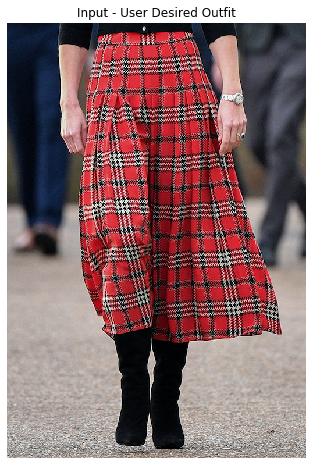

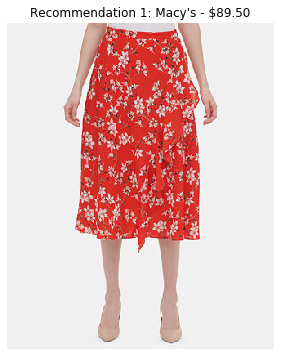

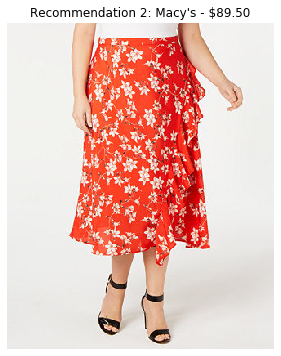

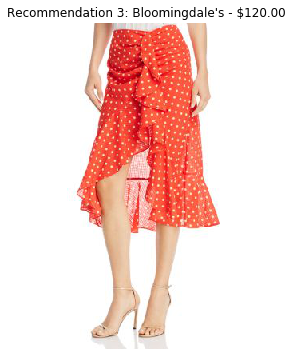

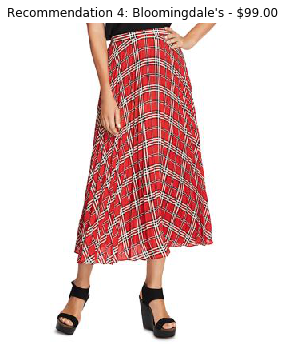

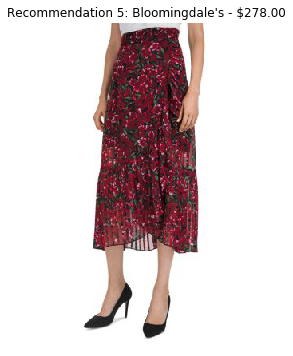

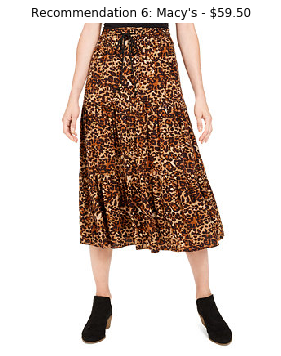

In [18]:
recommendation = recommendations_list[3] 
diretory_to_save = plot_recommendations(recommendation,
                     recommendation_name = "recommendation",
                     filter_by_type="skirt",
                     out_of_sample = "yes", 
                    remove_back = "no")

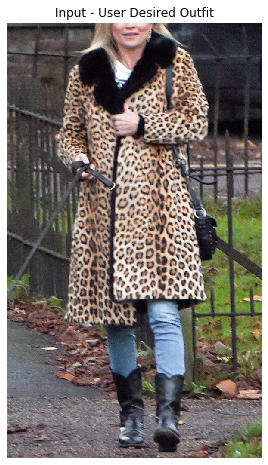

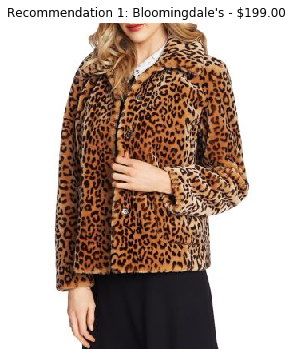

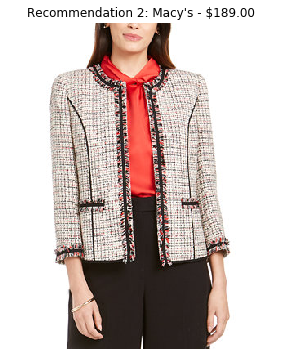

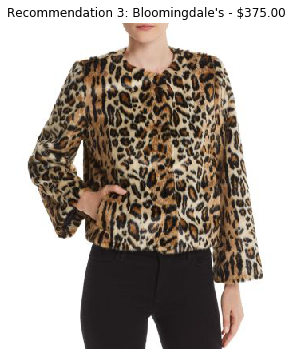

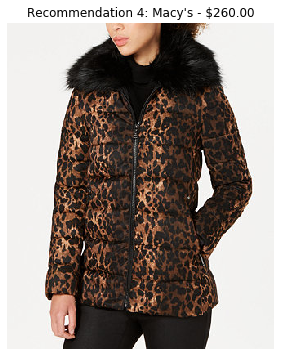

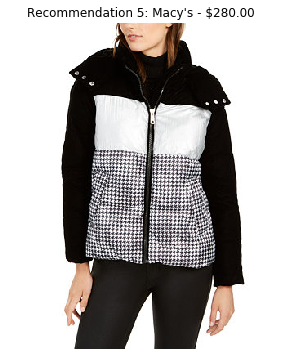

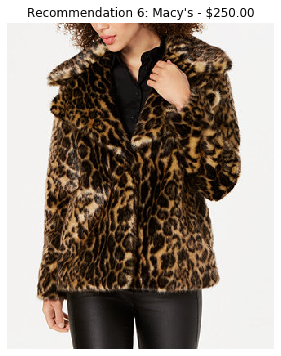

In [32]:
recommendation = recommendations_list[13] 
diretory_to_save = plot_recommendations(recommendation,
                     recommendation_name = "recommendation",
                     filter_by_type="coat",
                     out_of_sample = "yes", 
                    remove_back = "no")

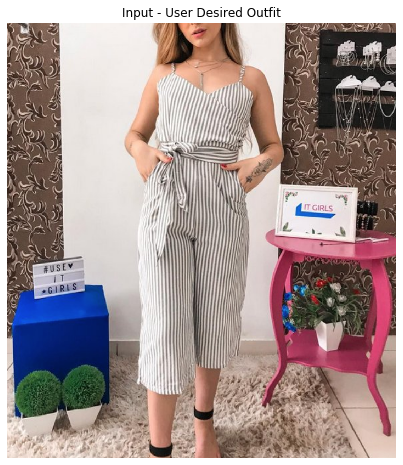

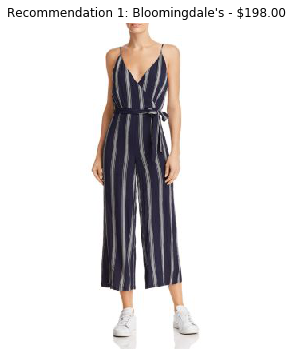

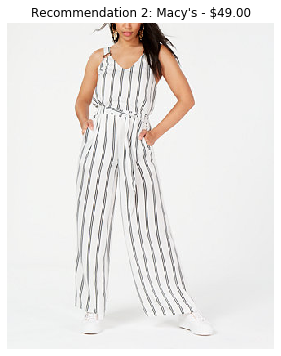

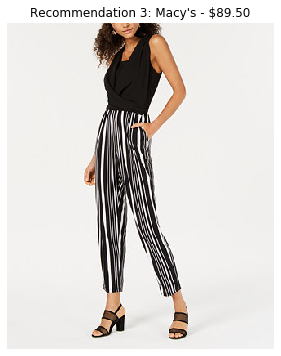

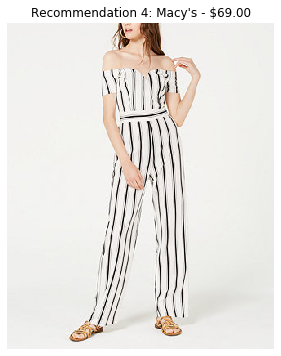

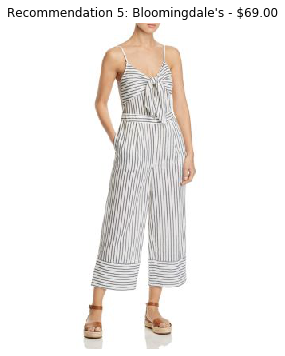

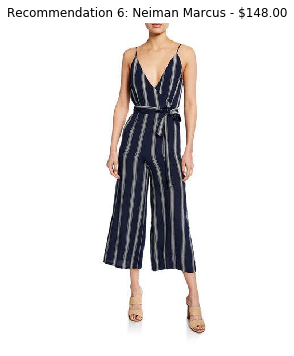

In [34]:
recommendation = recommendations_list[14] 
diretory_to_save = plot_recommendations(recommendation,
                     recommendation_name = "recommendation",
                     filter_by_type="jumpsuit",
                     out_of_sample = "yes", 
                    remove_back = "no")

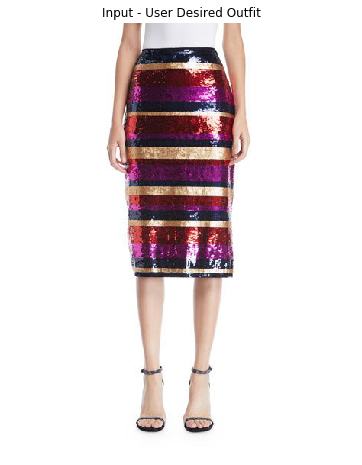

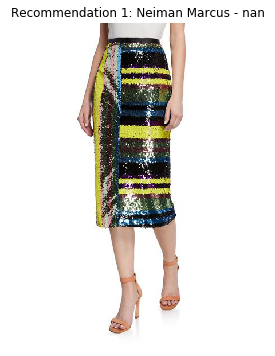

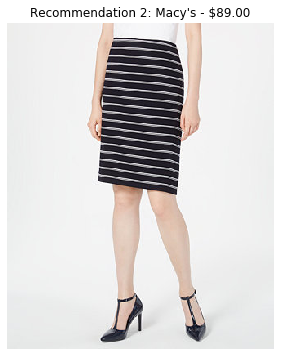

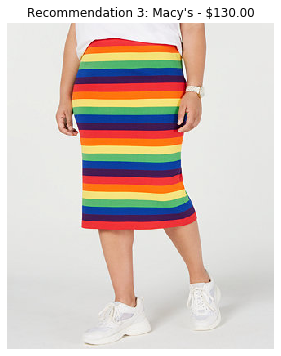

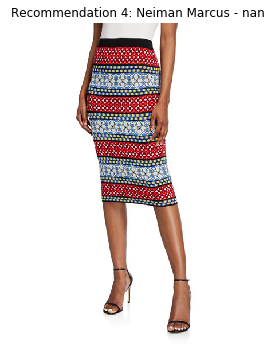

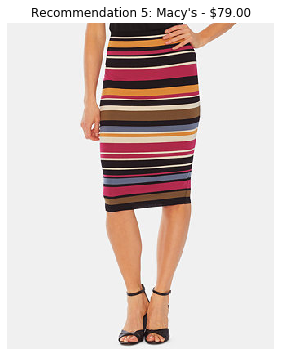

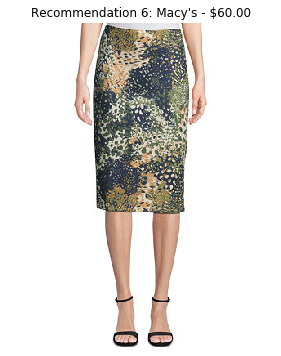

In [36]:
recommendation = recommendations_list[15] 
diretory_to_save = plot_recommendations(recommendation,
                     recommendation_name = "recommendation",
                     filter_by_type="skirt",
                     out_of_sample = "no", 
                    remove_back = "no")

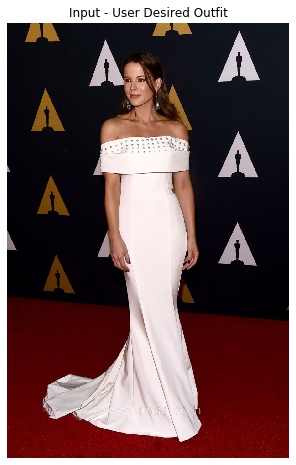

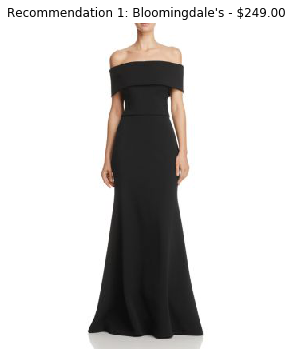

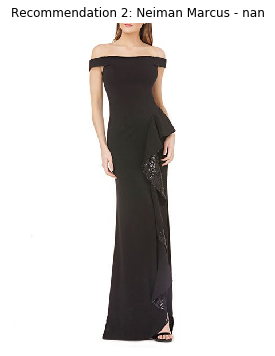

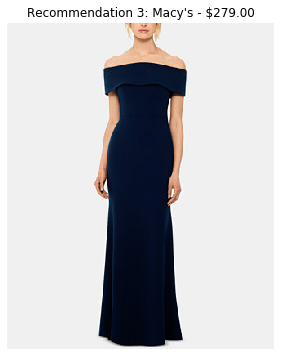

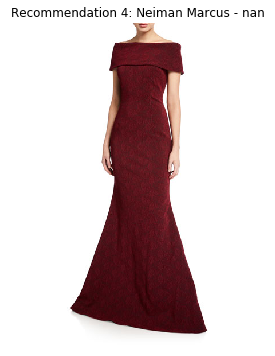

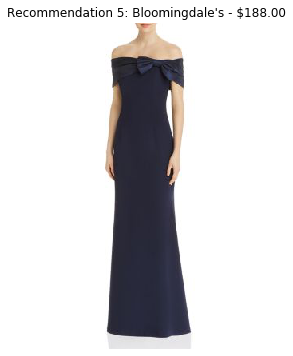

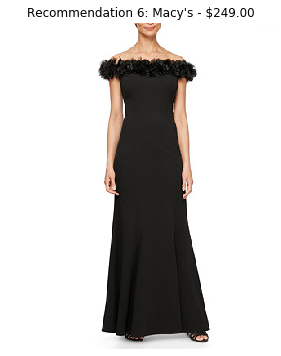

In [21]:
recommendation = recommendations_list[5] 
diretory_to_save = plot_recommendations(recommendation,
                     recommendation_name = "recommendation",
                     filter_by_type="dress",
                     out_of_sample = "yes", 
                    remove_back = "no")

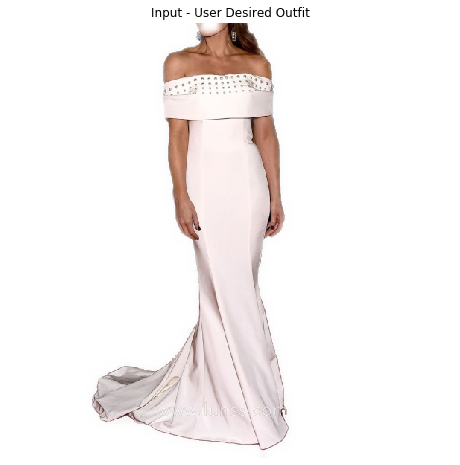

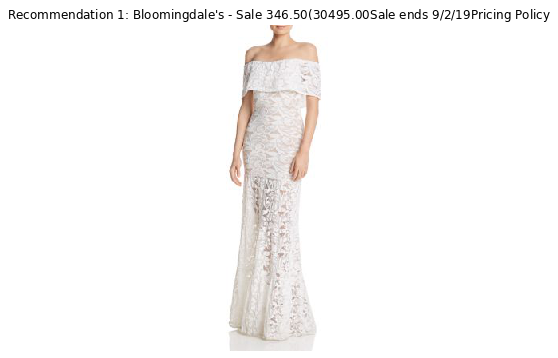

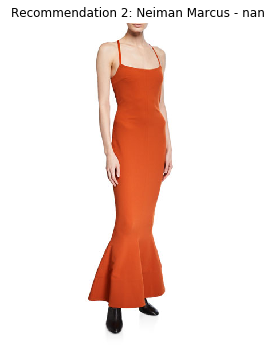

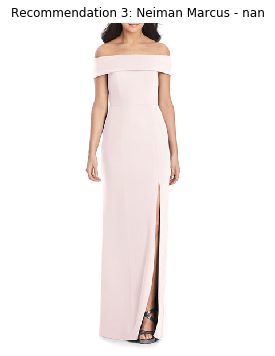

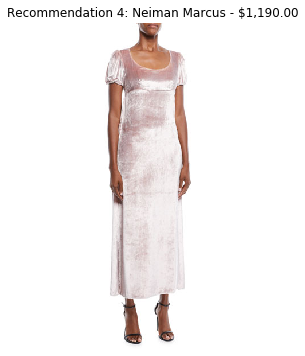

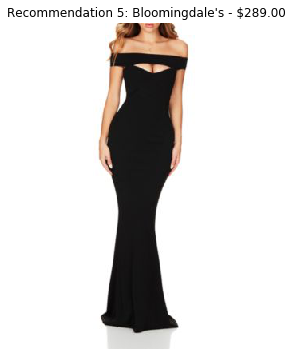

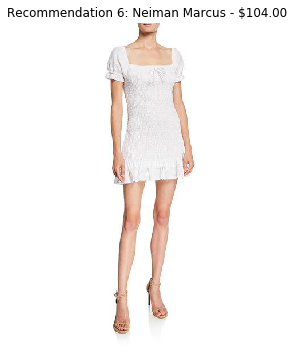

In [46]:
recommendation = recommendations_list[23] 
diretory_to_save = plot_recommendations(recommendation,
                     recommendation_name = "recommendation",
                     filter_by_type="dress",
                     out_of_sample = "yes", 
                    remove_back = "yes")